In [3]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ha-toxic-comment-classification/simple_sample_submission.csv
/kaggle/input/ha-toxic-comment-classification/simple_train.csv
/kaggle/input/ha-toxic-comment-classification/simple_test.csv


In [4]:
train = pd.read_csv('../input/ha-toxic-comment-classification/simple_train.csv')
test = pd.read_csv('../input/ha-toxic-comment-classification/simple_test.csv')
subm = pd.read_csv('../input/ha-toxic-comment-classification/simple_sample_submission.csv')

In [5]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

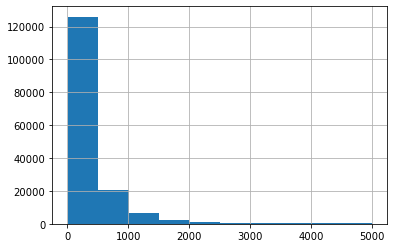

In [6]:
lens.hist()

In [7]:
label_cols = ['toxic']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

toxic           none
count  159571.000000  159571.000000
mean        0.095844       0.904156
std         0.294379       0.294379
min         0.000000       0.000000
25%         0.000000       1.000000
50%         0.000000       1.000000
75%         0.000000       1.000000
max         1.000000       1.000000

In [8]:
len(train),len(test)

(159571, 63978)

In [9]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [23]:
COMMENT = 'comment_text'
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(2,6), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [12]:
?TfidfVectorizer

In [24]:
trn_term_doc, test_term_doc

(<159571x1674486 sparse matrix of type '<class 'numpy.float64'>'
 	with 23832553 stored elements in Compressed Sparse Row format>,
 <63978x1674486 sparse matrix of type '<class 'numpy.float64'>'
 	with 7906844 stored elements in Compressed Sparse Row format>)

In [25]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [26]:
x = trn_term_doc
test_x = test_term_doc

In [28]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=0.1, dual=False, max_iter=5000)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [20]:
?LogisticRegression

In [29]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


In [30]:
submid = pd.DataFrame({'id': test["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission2.csv', index=False)

In [31]:
from IPython.display import FileLink
FileLink(r'submission2.csv')

/kaggle/working/submission2.csv